In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from scipy.stats import norm
import scipy.optimize as sco
import scipy


# Crypto Trend Following 

Using the MAN AHL method of combined signal. May try to use different lookbacks and weights in the future.

Sk=(8,16,32) and Lk=(24,48,96).

you need faster MAs than 16 and 32 I belive


In [3]:
# load help function

%run crypto_help.ipynb

In [4]:
dat_tmp = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [5]:
dat = dat_tmp['Close']

In [2]:
def AHL_signal(data, lookback = [4,4,4]):

    short  = data.ewm(span=lookback[0]).mean() - data.ewm(span=4*lookback[0]).mean()
    medium = data.ewm(span=lookback[1]).mean() - data.ewm(span=4*lookback[1]).mean()
    long = data.ewm(span=lookback[2]).mean() - data.ewm(span=4*lookback[2]).mean()

    #vol = dat.pct_change(1).rolling(63).std()
    vol = data.rolling(63).std()

    short_scld = short/vol
    medium_scld = medium/vol
    long_scld = long/vol

    short_norm = short_scld/short_scld.rolling(252).std()
    medium_norm = medium_scld/medium_scld.rolling(252).std()
    long_norm = long_scld/long_scld.rolling(252).std()

    short_sig = (short_norm * np.exp((-short_norm**2)/4))/0.89
    medium_sig = (medium_norm * np.exp((-medium_norm**2)/4))/0.89
    long_sig = (long_norm * np.exp((-long_norm**2)/4))/0.89

    short_sig = short_sig.dropna()
    medium_sig = medium_sig.dropna()
    long_sig = long_sig.dropna()

    comb_signal = (short_sig + medium_sig + long_sig)/3
    
    return(comb_signal)

### Backtest of signal for singel currency

In [6]:
back_dat = pd.concat([AHL_signal(dat), dat], axis=1)
back_dat = back_dat.dropna()
back_dat.columns = ['signal', 'price']

In [7]:
back_dat.loc[:, 'ret'] = back_dat['price'].pct_change().shift(-1)
back_dat.loc[:,'position'] = np.where(back_dat['signal']>0, 1,0)
back_dat.loc[:,'strategy_ret'] = back_dat['ret']*back_dat['position']
back_dat.loc[:,'strategy_cum'] = (back_dat['strategy_ret']+1).cumprod()
back_dat.loc[:,'bench_cum'] = (back_dat['ret']+1).cumprod()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


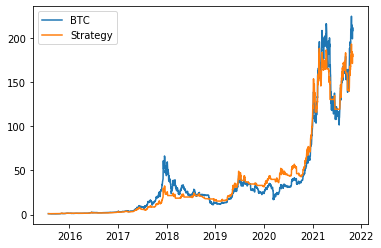

In [8]:
plt.plot(back_dat['bench_cum'], label = 'BTC');
plt.plot(back_dat['strategy_cum'], label = 'Strategy');
plt.legend();

In [9]:
trade_analysis(back_dat['position'])

Number of Trades:  71.0 
Average holding time:  19.0 
Trades per Year:  11.3


In [10]:
res = back_dat[['strategy_cum', 'bench_cum']].dropna()
strategy_evaluation(res, ['bench_cum'], 3000, freq = 'D')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,SWR,Skew,Kurtosis
Portfolio,77.3%,44.6%,1.51,1.58,-54%,1.43,61.3%,0.725,9.047
bench_cum,80.2%,63.2%,1.25,1.51,-83%,0.97,57.6%,-0.14,7.344


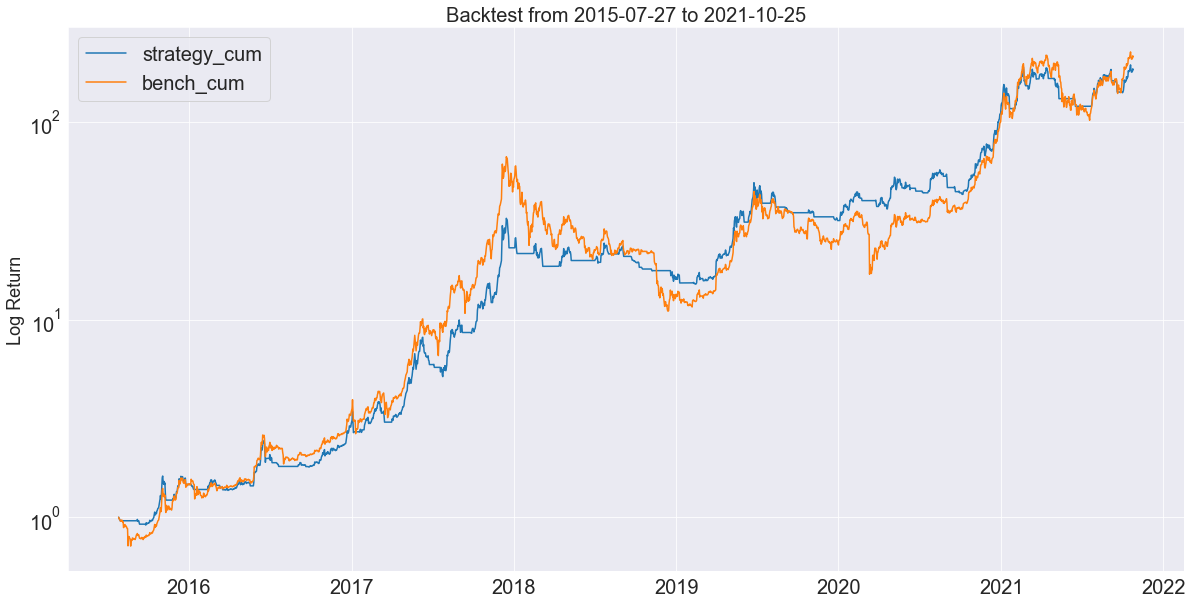

In [61]:
plot(res, "log") 

### Backtest of several crypto currencies

In [23]:
tickers = ['ETH-USD', 'BTC-USD', 'DOGE-USD', 'ADA-USD', 'XRP-USD', 'SOL-USD']
#tickers = ['ETH-USD', 'BTC-USD']
df_tick = pd.DataFrame()

In [24]:
for tick in tickers:
    coin_tmp = yf.download(tick)
    df_tick.loc[:,tick] = coin_tmp['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SOL-USD: No data found, symbol may be delisted


In [25]:
# generate signal 
df_signal = df_tick.apply(AHL_signal, axis = 0)
df_tick_ret = df_tick.pct_change().shift(-1)[:-1]


for col in df_tick_ret.columns:

    
    df_signal[col] = np.where(df_signal[col]>0, 1,0)

In [32]:
port_ret = np.multiply(df_signal[:-1],df_tick_ret[len(df_tick_ret) - len(df_signal) +1:]).sum(axis =1)
position_df = pd.DataFrame(df_signal[:-1].sum(axis =1))

#port_ret = port_ret.div(df_signal[:-1].sum(axis =1).values)
port_ret = port_ret.div(len(df_signal.columns))

port_ret = pd.DataFrame(port_ret)
port_ret.columns = ['port']
port_ret = port_ret.fillna(0) #fill with zero for no positions held


port_ret = (port_ret+1).cumprod()

bench_port = df_tick_ret[len(df_tick_ret) - len(df_signal) +1:].sum(axis =1)/len(df_tick_ret.columns)
bench_port = pd.DataFrame(bench_port)
bench_port.columns = ['bench']
bench_port = (bench_port+1).cumprod()

multi_df = pd.concat([port_ret,bench_port], axis = 1)

In [34]:
strategy_evaluation(multi_df, ['bench'], 3000, freq = 'D')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,SWR,Skew,Kurtosis
Portfolio,132.0%,43.0%,2.18,2.88,-29%,4.55,116.7%,4.026,57.681
bench,123.0%,65.1%,1.56,2.11,-84%,1.46,99.7%,1.476,19.274


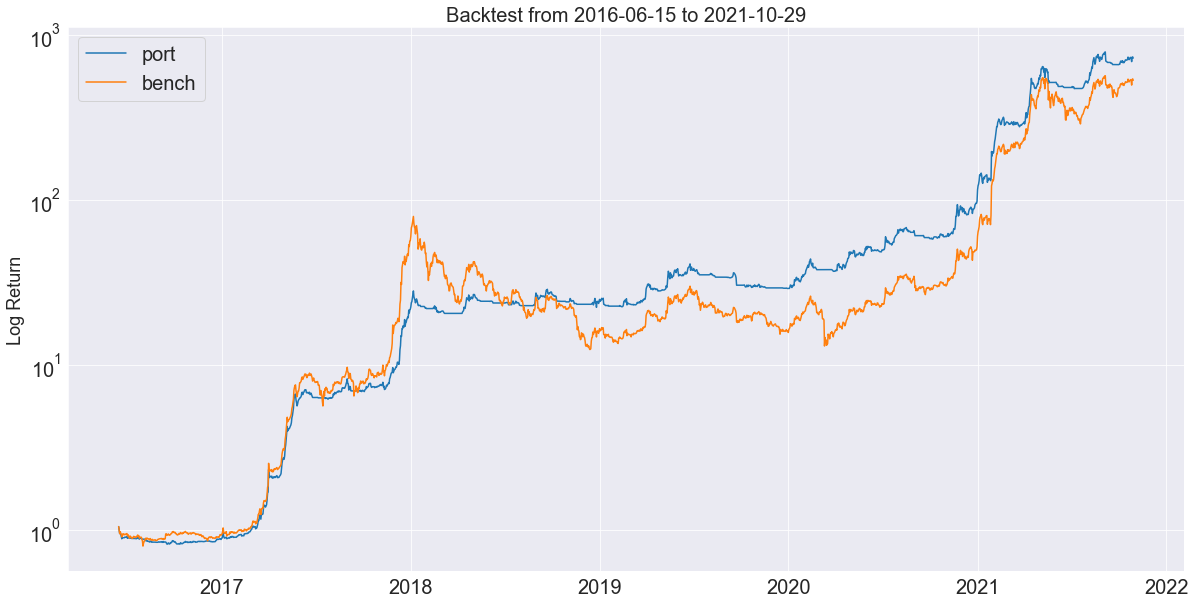

In [35]:
plot(multi_df, "log") 

## LONG/SHORT

In [ ]:
# generate signal 
df_signal_ls = df_tick.apply(AHL_signal, axis = 0)
df_tick_ret = df_tick.pct_change().shift(-1)[:-1]


for col in df_tick_ret.columns:

    
    df_signal_ls[col] = np.where(df_signal_ls[col]>0, 1,-1)

In [ ]:
port_ret_ls = np.multiply(df_signal_ls[:-1],df_tick_ret[len(df_tick_ret) - len(df_signal_ls) +1:]).sum(axis =1)
position_df = pd.DataFrame(df_signal_ls[:-1].sum(axis =1))

port_ret_ls = port_ret_ls.div(len(df_signal_ls.columns))

port_ret_ls = pd.DataFrame(port_ret_ls)
port_ret_ls.columns = ['port']
port_ret_ls = port_ret_ls.fillna(0) #fill with zero for no positions held


port_ret_ls = (port_ret_ls+1).cumprod()

bench_port_ls = df_tick_ret[len(df_tick_ret) - len(df_signal_ls) +1:].sum(axis =1)/len(df_tick_ret.columns)
bench_port_ls = pd.DataFrame(bench_port_ls)
bench_port_ls.columns = ['bench']
bench_port_ls = (bench_port_ls+1).cumprod()

multi_df = pd.concat([port_ret_ls,bench_port_ls], axis = 1)